In [18]:
import pandas as pd
import geopandas as gpd

In [19]:
df = pd.read_csv(r"D:\MECON\7. Ingreso Esperado\data\data_in\relative-wealth-index-april-2021\relative-wealth-index-april-2021\ARG_relative_wealth_index.csv")

In [20]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

In [21]:
gdf = gdf.set_crs(4326)
gdf

,quadkey,latitude,longitude,rwi,error,geometry
0,21032130010323,-34.443158,-58.590088,1.150,0.452,POINT (-58.59009 -34.44316)
1,21032122000123,-35.523285,-61.754150,-0.415,0.410,POINT (-61.75415 -35.52328)
2,21032123111002,-35.487510,-59.227295,-0.252,0.409,POINT (-59.22729 -35.48751)
3,21030300312131,-27.887639,-60.655518,-0.805,0.397,POINT (-60.65552 -27.88764)
4,21032313000332,-37.848832,-57.513428,0.792,0.458,POINT (-57.51343 -37.84883)
...,...,...,...,...,...,...
36772,21030212101023,-28.372068,-63.775635,-0.040,0.430,POINT (-63.77563 -28.37207)
36773,21030322023321,-31.325486,-61.578369,0.024,0.444,POINT (-61.57837 -31.32549)
36774,21030201030333,-27.518015,-65.577393,-0.101,0.480,POINT (-65.57739 -27.51801)
36775,21030032121001,-26.125850,-63.775635,-0.252,0.456,POINT (-63.77563 -26.12585)


<AxesSubplot:>

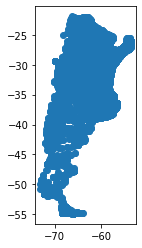

In [22]:
gdf.plot()

In [23]:
# # Cambio el CRS
# gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)

# # Obtengo string para calcular en el mapa de cuanto son los rasters
# from shapely import wkt
# gdf['str_geom'] = gdf.geometry.apply(lambda x: wkt.dumps(x))

# # Genero los rasters (envelope me genera el cuadrado)
# raster_size = 2445
# gdf['geometry'] = gdf.buffer(raster_size/2).envelope

In [24]:
icpag = gpd.read_file(r"R:\Shapefiles\ICPAG\Sin barrios pop y cerr\Full\base_icpag_full.shp")

In [25]:
gdf_min = gdf[['rwi','error', 'geometry']].to_crs(epsg=4326)
icpag_min = icpag[['link', 'geometry']]

sjoined = icpag_min.sjoin(gdf_min)
sjoined = sjoined.groupby('link').agg({'rwi':'mean', 'error':'mean'}).reset_index()

### SOLO para rasterización del WRI
# sjoined = icpag_min.sjoin(gdf_min, predicate='within') # Hago within dropeando los RC que están entre dos rasters del rwi

In [26]:
indicators = icpag.merge(sjoined[['link','rwi','error']], on='link', how='outer', indicator=True)

In [27]:
# Invierto nbi
indicators['no_nbi_p'] = 1- indicators['nbi_rc_val']

# Solo cols relevantes
indicators = indicators[
    [ 'eph_codagl','eph_aglome','aglo_eph','AMBA_legal',] + 
    ['link','rwi','rmax','icv2010','pm2','no_nbi_p']
]

In [28]:
indicators[['rwi','rmax','icv2010','pm2','no_nbi_p']].corr('spearman')

,rwi,rmax,icv2010,pm2,no_nbi_p
rwi,1.000000,0.448689,0.240717,0.249669,0.178450
rmax,0.448689,1.000000,0.814145,0.773661,0.726898
icv2010,0.240717,0.814145,1.000000,0.558720,0.708700
pm2,0.249669,0.773661,0.558720,1.000000,0.356603
no_nbi_p,0.178450,0.726898,0.708700,0.356603,1.000000


In [29]:
indicators.to_csv(r'D:\MECON\7. Ingreso Esperado\data\data_out\indicadores espaciales.csv', index=False)